# Chapter 2 - End-to-end Machine Learning Project

In [1]:
print("Welcome to Machine Learning!")

Welcome to Machine Learning!


In [2]:
import sys
assert sys.version_info >= (3, 7)

In [3]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [4]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
        housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

/var/folders/mb/nl14zq052xb365n_snp1wspr0000gn/T/ipykernel_65822/2608961671.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tarball.extractall(path="datasets")


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


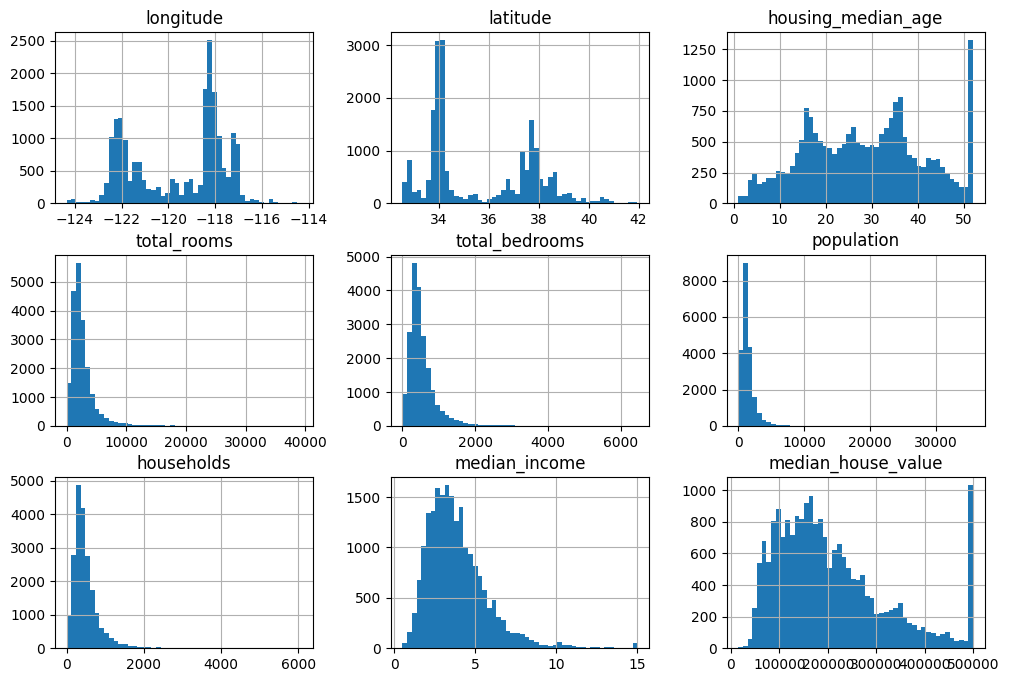

In [8]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(12, 8))
plt.show()

In [9]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffle_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffle_indices[:test_set_size]
    train_indices = shuffle_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2 ** 32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
housing_with_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [12]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [13]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

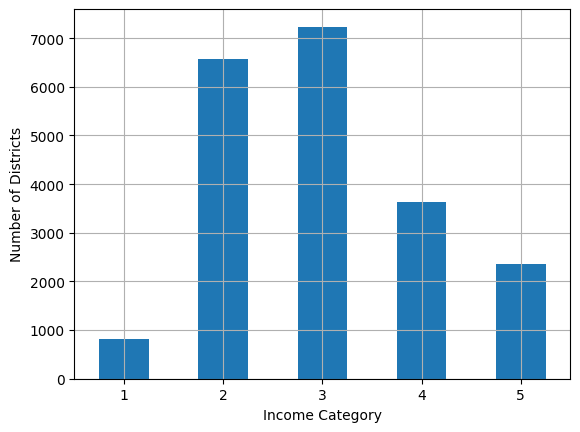

In [14]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of Districts")
plt.show()

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append((strat_train_set_n, strat_test_set_n))

In [16]:
strat_train_set, strat_test_set = strat_splits[0]

strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, random_state=42, stratify=housing["income_cat"])

In [17]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [18]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [19]:
housing = strat_train_set.copy()

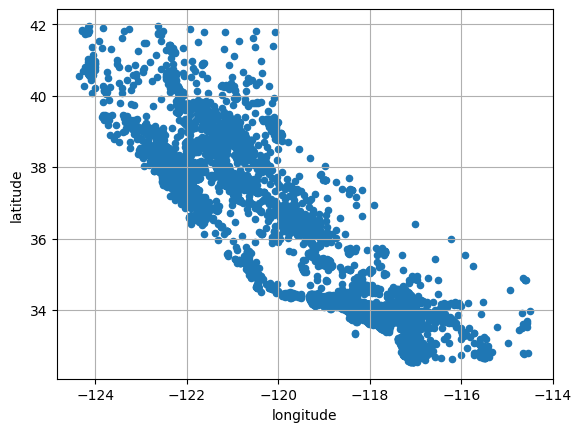

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

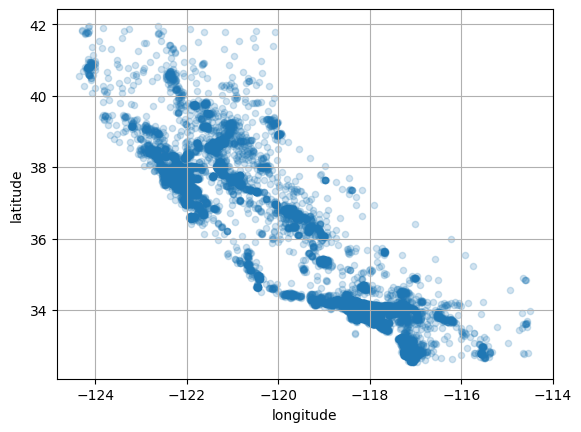

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

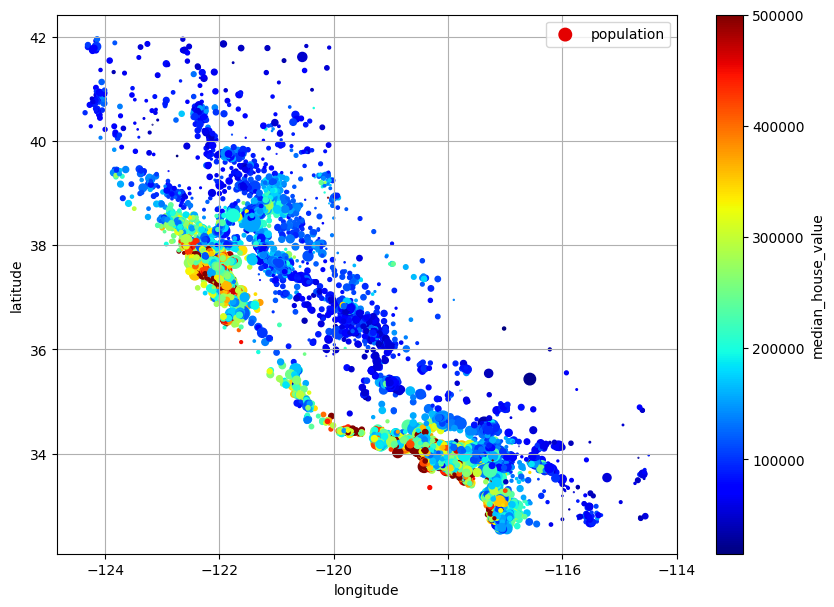

In [22]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, s=housing["population"]/100, label="population", c="median_house_value", cmap="jet", colorbar=True, legend=True, sharex=False, figsize=(10, 7))
plt.show()

In [23]:
corr_matrix = housing.corr(numeric_only=True)

In [24]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

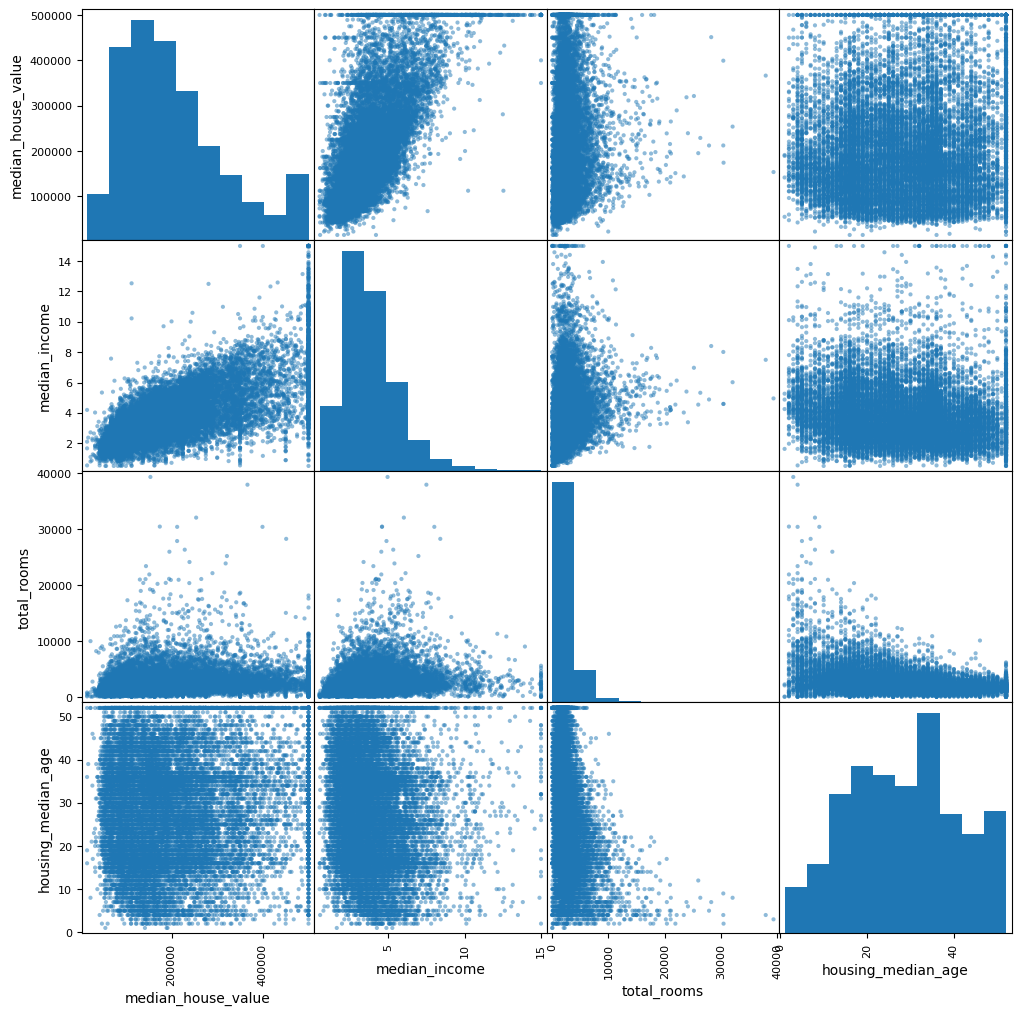

In [25]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 12))
plt.show()

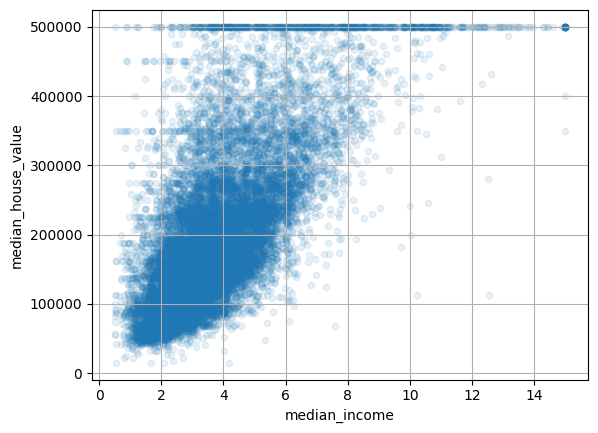

In [26]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)
plt.show()

In [27]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [28]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value     1.000000
median_income          0.688380
rooms_per_household    0.143663
total_rooms            0.137455
housing_median_age     0.102175
households             0.071426
total_bedrooms         0.054635
population            -0.020153
people_per_house      -0.038224
longitude             -0.050859
latitude              -0.139584
bedrooms_ratio        -0.256397
Name: median_house_value, dtype: float64

In [29]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [30]:
# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"] = housing["total_bedrooms"].fillna(median)

In [31]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [32]:
imputer.statistics_
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [33]:
X = imputer.transform(housing_num)

In [34]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [35]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [36]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [37]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [38]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [39]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [40]:
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [41]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], shape=(16512, 5))

In [42]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [43]:
df_test = pd.DataFrame({
    'ocean_proximity': ['INLAND', 'NEAR OCEAN']})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR OCEAN
0,True,False
1,False,True


In [45]:
cat_encoder.transform(df_test).toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [48]:
df_test_unknown = pd.DataFrame({
    'ocean_proximity': ['<2H OCEAN', 'ISLAND']})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [51]:
cat_encoder.handle_unknown = 'ignore'
cat_encoder.transform(df_test_unknown).toarray()

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [54]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [55]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [61]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown).toarray(), columns=cat_encoder.get_feature_names_out(), index=df_test_unknown.index)
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


In [63]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)
housing_num_min_max_scaled

array([[-0.60851927,  0.11702128,  1.        , ..., -0.80701754,
        -0.61433638, -0.7794789 ],
       [ 0.21095335, -0.66170213,  0.52941176, ..., -0.91866029,
        -0.86708979, -0.22929339],
       [-0.51926978,  0.23617021,  0.25490196, ..., -0.93141946,
        -0.92458466, -0.73336919],
       ...,
       [ 0.47870183, -0.99148936, -0.52941176, ..., -0.65513434,
        -0.71663244, -0.50873781],
       [ 0.20689655, -0.6787234 ,  0.41176471, ..., -0.78873758,
        -0.68751167, -0.49716556],
       [-0.60649087,  0.08723404,  0.68627451, ..., -0.91669734,
        -0.92122457, -0.61608805]], shape=(16512, 8))

In [65]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_standardized = std_scaler.fit_transform(housing_num)
housing_num_standardized

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.13746004,
         1.39481249, -0.93649149],
       [ 0.59639445, -0.702103  ,  0.90762971, ..., -0.69377062,
        -0.37348471,  1.17194198],
       [-1.2030985 ,  1.27611874,  0.35142777, ..., -0.78876841,
        -0.77572662, -0.75978881],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  1.26829911,
         0.67913534,  0.1010487 ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.27356264,
         0.88286825,  0.14539615],
       [-1.41803793,  0.94797769,  1.22545939, ..., -0.67915557,
        -0.75221898, -0.31034135]], shape=(16512, 8))

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel
age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]], shape=(16512, 1))

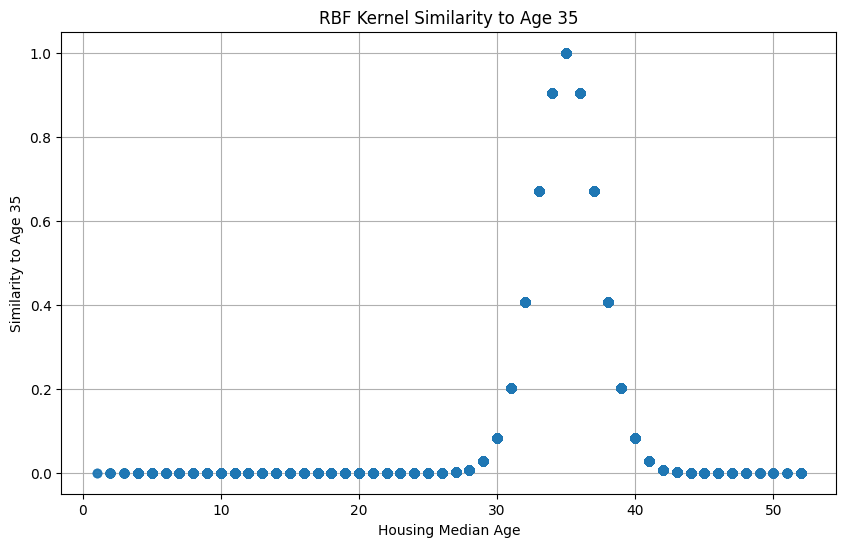

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(housing["housing_median_age"], age_simil_35, "o", alpha=0.5)
plt.xlabel("Housing Median Age")
plt.ylabel("Similarity to Age 35")
plt.title("RBF Kernel Similarity to Age 35")
plt.grid(True)
plt.show()

In [69]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [70]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

In [ ]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])
log_pop

,population
13096,7.362645
14973,6.501290
3785,6.331502
14689,7.520235
20507,7.555905
...,...
14207,6.843750
13105,7.257708
19301,7.942362
19121,7.452982


In [73]:
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]], shape=(16512, 1))